### Protein Family Classification

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pickle

from collections import Counter

In [2]:
family_classification_metadata = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [3]:
def get_families(qty=1000):
    family_counter = Counter()

    for protein_meta in family_classification_metadata['FamilyID']:
        family_counter[protein_meta] += 1

    most_common_families = family_counter.most_common(qty)
    famili_dict = dict()

    for index, (family, _) in enumerate(most_common_families):
        famili_dict[family] = index
    
    return famili_dict

def get_prot2vec():
    prot2vec = pd.read_csv('../seminar_6/data/protVec_100d_3grams.csv').as_matrix()
    
    trigram_to_vec = dict()
    
    for i in range(prot2vec.shape[0]):
        protein = prot2vec[i, 0]
        protein = protein.split()
        trigram = protein[0]
        vec = np.array(list(map(lambda x: float(x), protein[1:])))
        trigram_to_vec[trigram] = vec
        
    return trigram_to_vec

In [4]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [51]:
family2num = read_or_create(read_path='data/families.pickle',
                          producer=get_families)

prot2vec = read_or_create(read_path='data/prot2vec.pickle',
                          producer=get_prot2vec)

reading data/families.pickle
reading data/prot2vec.pickle


In [127]:
MAX_PROTEIN_LEN = 600
VECTOR_LEN = 100
BATCH_SIZE = 256
NUM_CLASSES = 1000


proteins = np.array(family_classification_sequences['Sequences'])
families = np.array(family_classification_metadata['FamilyID'])

allowed_indices = list()

for i in range(proteins.shape[0]):
    if len(proteins[i]) > MAX_PROTEIN_LEN or families[i] not in family2num:
        continue
    allowed_indices.append(i)

allowed_indices = np.array(allowed_indices)
np.random.shuffle(allowed_indices)

train_ratio = 0.9

train_inds = allowed_indices[:int(allowed_indices.shape[0] * train_ratio)]
test_inds = allowed_indices[int(allowed_indices.shape[0] * train_ratio):]


def process_proteins(proteins, prot2vec):
        def process_protein(protein, prot2vec):
            embeded = list()
            for i in range(0, len(protein) - 3, 3):
                try:
                    embeded.append(prot2vec[protein[i: i + 3]])
                except KeyError:
                    embeded.append(prot2vec['<unk>'])

            embeded = np.array(embeded)
            
            if (embeded.shape[0] < MAX_PROTEIN_LEN / 3):
                embeded = np.vstack((embeded, np.zeros(shape=(MAX_PROTEIN_LEN - embeded.shape[0], VECTOR_LEN))))

            return embeded
    
        prots = list()
        
        for i in range(proteins.shape[0]):
            prots.append(process_protein(proteins[i], prot2vec))
    
        return np.array(prots)

def process_proteins_for_sklearn(proteins, prot2vec):
        def process_protein(protein, prot2vec):
            embeded = list()
            for i in range(0, len(protein) - 3, 3):
                try:
                    embeded.append(prot2vec[protein[i: i + 3]])
                except KeyError:
                    embeded.append(prot2vec['<unk>'])
            
            embeded_prot = embeded[0]
            
            for i in range(1, len(embeded)):
                embeded_prot += embeded[i]
            
            embeded_prot /= len(embeded)
            
            return embeded_prot
    
        prots = list()
        
        for i in range(proteins.shape[0]):
            prots.append(process_protein(proteins[i], prot2vec))
    
        return np.array(prots)    

        
def process_families(families, family2num):
        fams = list()
        
        for i in range(families.shape[0]):
            fams.append(family2num[families[i]])
        fams = np.array(fams)
        return np.eye(NUM_CLASSES)[fams]
        
        
def process_families_single(families, family2num):
        fams = list()
        
        for i in range(families.shape[0]):
            try:
                fams.append(family2num[families[i]])
            except KeyError:
                fams.append(1000)
        return np.array(fams)
    
        
def generate_batch(proteins, families, prot2vec, family2num, train_inds):
    while True:
        batch_inds = np.random.choice(train_inds, BATCH_SIZE)
        batch_prots = process_proteins(proteins[batch_inds], prot2vec)
        batch_families = process_families(families[batch_inds], family2num)
        yield batch_prots, batch_families

        
def generate_test(proteins, families, prot2vec, family2num, test_inds):  
    for i in range(0, test_inds.shape[0], BATCH_SIZE):
        batch_inds = test_inds[i: i + BATCH_SIZE]
        batch_prots = process_proteins(proteins[batch_inds], prot2vec)
        batch_families = process_families(families[batch_inds], family2num)
        yield batch_prots, batch_families

In [7]:
from lazy import lazy

class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, NUM_CLASSES])
            self.target
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
    # First, we obtain the lengths of sequences in the current data batch. We need this since
    # the data comes as a single tensor, padded with zero vectors to the longest review length.
    # Instead of keeping track of the sequence lengths of every review, we just compute it
    # dynamically in TensorFlow.
    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
    # Note that the last relevant output activation of the RNN has a different index for each
    # sequence in the training batch. This is because each review has a different length. We
    # already know the length of each sequence.
    # The problem is that we want to index in the dimension of time steps, which is
    # the second dimension in the batch of shape  (sequences, time_steps, word_vectors) .
    
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # RNNs are quite hard to train and weights tend to diverge if the hyper parameters do not
    # play nicely together. The idea of gradient clipping is to restrict the the values of the
    # gradient to a sensible range. This way, we can limit the maximum weight updates.

        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            # As of now, TensorFlow only supports indexing along the first dimension, using
            # tf.gather() . We thus flatten the first two dimensions of the output activations from their
            # shape of  sequences x time_steps x word_vectors  and construct an index into this resulting tensor.
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            # The index takes into account the start indices for each sequence in the flat tensor and adds
            # the sequence length to it. Actually, we only add  length - 1  so that we select the last valid
            # time step.
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [8]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=256,
    optimizer=tf.train.AdamOptimizer(0.001),
    batch_size=BATCH_SIZE,
    gradient_clipping=100,
    seq_length=MAX_PROTEIN_LEN,
    embed_length=VECTOR_LEN
)

In [9]:
tf.reset_default_graph()

model = SequenceClassificationModel(params)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [10]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)

iterations = 10000

saver = tf.train.Saver()
save_path = 'checkpoints/rnn'

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    
    batch_generator = generate_batch(proteins, families, prot2vec, 
                                     family2num, train_inds)
    
    for index, batch in enumerate(batch_generator):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        print('{}: {:3.1f}%'.format(index + 1, 100 * (1 - error)))
        if index % 10 == 0:
            summary_writer.add_summary(summary_str, index)
        if index % 100 == 0:
            saver.save(sess, save_path, index)
        if index == iterations:
            break
    
    test_generator = generate_test(proteins, families, prot2vec, 
                                   family2num, test_inds)
    
    mean_error = 0
    count = 0
    
    print('testing...')
    
    for index, batch in enumerate(test_generator):
        feed = {model.data: batch[0], model.target: batch[1]}
        error = sess.run(model.error, feed)
        mean_error += error
        count += 1
        print('{}: {:3.1f}%'.format(index + 1, 100 * (1 - error)))
    
    print('accuracy on testing: {:3.4f}%'.format(100 * (1 - mean_error / count)))
    

1: 0.0%
2: 0.0%
3: 1.2%
4: 3.1%
5: 2.0%
6: 2.0%
7: 2.3%
8: 0.8%
9: 0.4%
10: 1.6%
11: 0.8%
12: 2.0%
13: 1.2%
14: 1.2%
15: 0.8%
16: 1.6%
17: 2.3%
18: 0.8%
19: 1.6%
20: 1.2%
21: 1.2%
22: 0.8%
23: 0.8%
24: 1.6%
25: 2.7%
26: 1.6%
27: 0.0%
28: 0.8%
29: 0.8%
30: 0.8%
31: 1.2%
32: 0.4%
33: 2.0%
34: 2.3%
35: 0.8%
36: 0.4%
37: 0.8%
38: 2.3%
39: 2.3%
40: 2.7%
41: 1.2%
42: 2.0%
43: 2.0%
44: 1.2%
45: 1.6%
46: 0.8%
47: 1.6%
48: 1.6%
49: 2.3%
50: 0.8%
51: 2.3%
52: 2.0%
53: 2.0%
54: 2.0%
55: 0.8%
56: 1.6%
57: 2.7%
58: 1.2%
59: 0.8%
60: 0.4%
61: 0.8%
62: 2.0%
63: 2.0%
64: 1.6%
65: 1.6%
66: 2.0%
67: 1.2%
68: 1.2%
69: 1.6%
70: 2.0%
71: 1.2%
72: 2.0%
73: 0.8%
74: 1.6%
75: 3.5%
76: 1.2%
77: 0.8%
78: 2.3%
79: 2.0%
80: 3.1%
81: 2.3%
82: 2.7%
83: 3.5%
84: 2.3%
85: 3.5%
86: 1.6%
87: 2.0%
88: 2.7%
89: 2.3%
90: 1.2%
91: 1.6%
92: 1.2%
93: 2.3%
94: 1.6%
95: 1.6%
96: 2.7%
97: 0.8%
98: 1.6%
99: 1.6%
100: 0.8%
101: 2.0%
102: 2.7%
103: 2.0%
104: 2.7%
105: 3.1%
106: 2.3%
107: 3.9%
108: 3.9%
109: 1.6%
110: 1.2%
111: 2.7

797: 18.4%
798: 14.5%
799: 15.2%
800: 17.2%
801: 10.9%
802: 15.6%
803: 15.6%
804: 16.8%
805: 12.9%
806: 14.8%
807: 10.9%
808: 16.0%
809: 13.3%
810: 13.3%
811: 17.2%
812: 10.9%
813: 12.9%
814: 13.3%
815: 12.5%
816: 15.6%
817: 14.5%
818: 15.2%
819: 19.9%
820: 20.7%
821: 16.8%
822: 14.8%
823: 15.2%
824: 16.0%
825: 13.3%
826: 12.9%
827: 13.3%
828: 18.8%
829: 14.1%
830: 15.6%
831: 19.5%
832: 14.8%
833: 15.6%
834: 14.5%
835: 20.3%
836: 18.0%
837: 15.2%
838: 12.9%
839: 13.3%
840: 12.1%
841: 13.7%
842: 17.6%
843: 12.9%
844: 11.7%
845: 17.2%
846: 14.1%
847: 13.3%
848: 20.3%
849: 19.5%
850: 17.2%
851: 16.0%
852: 14.1%
853: 12.5%
854: 14.8%
855: 12.1%
856: 16.4%
857: 20.7%
858: 14.1%
859: 13.3%
860: 12.5%
861: 13.3%
862: 10.9%
863: 10.2%
864: 16.4%
865: 18.4%
866: 15.2%
867: 15.6%
868: 13.7%
869: 18.0%
870: 14.8%
871: 14.5%
872: 14.1%
873: 18.4%
874: 17.6%
875: 19.5%
876: 18.0%
877: 14.8%
878: 14.8%
879: 18.8%
880: 13.7%
881: 15.2%
882: 20.3%
883: 12.1%
884: 14.1%
885: 18.0%
886: 17.2%
887: 12.5%

1516: 10.9%
1517: 14.5%
1518: 16.8%
1519: 14.5%
1520: 18.8%
1521: 13.7%
1522: 13.7%
1523: 16.0%
1524: 15.2%
1525: 15.6%
1526: 15.6%
1527: 18.8%
1528: 15.2%
1529: 13.3%
1530: 14.5%
1531: 11.7%
1532: 13.7%
1533: 12.9%
1534: 13.7%
1535: 18.4%
1536: 15.2%
1537: 11.7%
1538: 14.8%
1539: 14.1%
1540: 13.3%
1541: 17.2%
1542: 14.1%
1543: 13.3%
1544: 16.0%
1545: 16.0%
1546: 19.1%
1547: 14.1%
1548: 16.8%
1549: 16.4%
1550: 13.7%
1551: 16.0%
1552: 12.9%
1553: 16.0%
1554: 19.5%
1555: 21.1%
1556: 17.2%
1557: 19.5%
1558: 19.1%
1559: 14.1%
1560: 14.8%
1561: 16.4%
1562: 16.0%
1563: 17.2%
1564: 12.5%
1565: 22.7%
1566: 18.4%
1567: 16.4%
1568: 13.3%
1569: 16.8%
1570: 17.6%
1571: 20.3%
1572: 17.2%
1573: 18.8%
1574: 18.0%
1575: 10.9%
1576: 14.1%
1577: 21.9%
1578: 16.0%
1579: 22.7%
1580: 19.1%
1581: 15.2%
1582: 21.5%
1583: 16.4%
1584: 18.8%
1585: 18.4%
1586: 19.1%
1587: 16.0%
1588: 12.9%
1589: 14.8%
1590: 18.8%
1591: 19.9%
1592: 18.4%
1593: 18.8%
1594: 14.8%
1595: 23.8%
1596: 20.3%
1597: 18.0%
1598: 18.4%
1599

2199: 32.8%
2200: 35.9%
2201: 36.7%
2202: 32.0%
2203: 28.5%
2204: 38.3%
2205: 36.3%
2206: 41.4%
2207: 32.0%
2208: 38.3%
2209: 37.5%
2210: 41.0%
2211: 36.7%
2212: 32.8%
2213: 35.9%
2214: 38.3%
2215: 35.9%
2216: 36.7%
2217: 38.3%
2218: 35.2%
2219: 35.2%
2220: 33.2%
2221: 39.1%
2222: 34.4%
2223: 42.6%
2224: 39.5%
2225: 33.2%
2226: 41.4%
2227: 34.8%
2228: 33.2%
2229: 36.7%
2230: 40.2%
2231: 35.2%
2232: 37.9%
2233: 34.8%
2234: 35.5%
2235: 41.8%
2236: 34.8%
2237: 32.4%
2238: 40.2%
2239: 42.6%
2240: 35.9%
2241: 37.1%
2242: 37.9%
2243: 39.5%
2244: 39.5%
2245: 37.9%
2246: 39.1%
2247: 32.0%
2248: 41.4%
2249: 38.3%
2250: 38.7%
2251: 39.5%
2252: 36.7%
2253: 36.7%
2254: 37.1%
2255: 39.1%
2256: 39.1%
2257: 34.4%
2258: 35.5%
2259: 39.1%
2260: 35.5%
2261: 35.9%
2262: 41.8%
2263: 41.8%
2264: 34.8%
2265: 44.1%
2266: 41.8%
2267: 33.6%
2268: 33.6%
2269: 34.8%
2270: 36.7%
2271: 35.9%
2272: 37.9%
2273: 34.8%
2274: 35.9%
2275: 30.5%
2276: 39.8%
2277: 41.0%
2278: 39.8%
2279: 41.4%
2280: 37.9%
2281: 41.0%
2282

2882: 49.6%
2883: 54.3%
2884: 57.8%
2885: 50.8%
2886: 52.7%
2887: 54.3%
2888: 53.9%
2889: 47.3%
2890: 50.4%
2891: 50.0%
2892: 55.1%
2893: 51.2%
2894: 54.7%
2895: 59.0%
2896: 60.2%
2897: 53.1%
2898: 52.3%
2899: 52.3%
2900: 53.5%
2901: 50.0%
2902: 47.7%
2903: 52.7%
2904: 50.8%
2905: 53.5%
2906: 53.5%
2907: 53.1%
2908: 54.3%
2909: 55.5%
2910: 51.6%
2911: 48.0%
2912: 52.7%
2913: 52.3%
2914: 52.3%
2915: 58.6%
2916: 51.2%
2917: 53.9%
2918: 50.0%
2919: 55.1%
2920: 52.0%
2921: 50.0%
2922: 56.6%
2923: 57.8%
2924: 55.1%
2925: 55.5%
2926: 54.7%
2927: 55.9%
2928: 52.7%
2929: 50.0%
2930: 56.6%
2931: 50.4%
2932: 53.9%
2933: 52.3%
2934: 56.6%
2935: 52.3%
2936: 56.2%
2937: 54.3%
2938: 57.8%
2939: 55.1%
2940: 56.2%
2941: 48.4%
2942: 56.6%
2943: 54.3%
2944: 55.1%
2945: 53.5%
2946: 60.5%
2947: 60.2%
2948: 57.4%
2949: 57.0%
2950: 62.5%
2951: 52.0%
2952: 56.6%
2953: 54.7%
2954: 57.4%
2955: 54.3%
2956: 56.2%
2957: 48.0%
2958: 51.2%
2959: 48.4%
2960: 52.0%
2961: 51.6%
2962: 46.5%
2963: 55.5%
2964: 57.0%
2965

3565: 62.5%
3566: 62.1%
3567: 69.5%
3568: 60.2%
3569: 65.6%
3570: 63.7%
3571: 68.8%
3572: 64.1%
3573: 70.7%
3574: 69.5%
3575: 66.4%
3576: 70.3%
3577: 66.4%
3578: 70.3%
3579: 69.1%
3580: 67.2%
3581: 75.4%
3582: 67.6%
3583: 68.4%
3584: 66.8%
3585: 68.8%
3586: 68.8%
3587: 68.0%
3588: 66.4%
3589: 66.8%
3590: 63.3%
3591: 73.0%
3592: 65.6%
3593: 67.2%
3594: 68.0%
3595: 70.3%
3596: 71.5%
3597: 69.1%
3598: 67.6%
3599: 69.5%
3600: 61.3%
3601: 69.1%
3602: 67.2%
3603: 73.0%
3604: 72.3%
3605: 68.8%
3606: 73.0%
3607: 69.1%
3608: 65.6%
3609: 68.0%
3610: 68.0%
3611: 71.9%
3612: 72.7%
3613: 65.6%
3614: 69.5%
3615: 71.9%
3616: 68.8%
3617: 70.3%
3618: 62.5%
3619: 69.5%
3620: 66.8%
3621: 64.5%
3622: 75.0%
3623: 69.1%
3624: 64.8%
3625: 66.8%
3626: 60.2%
3627: 67.6%
3628: 70.7%
3629: 66.0%
3630: 70.3%
3631: 67.2%
3632: 69.1%
3633: 63.7%
3634: 70.3%
3635: 63.3%
3636: 71.1%
3637: 68.4%
3638: 69.5%
3639: 68.8%
3640: 67.6%
3641: 68.0%
3642: 71.5%
3643: 63.3%
3644: 73.4%
3645: 68.4%
3646: 66.4%
3647: 71.5%
3648

4248: 73.0%
4249: 72.3%
4250: 74.6%
4251: 69.1%
4252: 76.2%
4253: 78.1%
4254: 78.1%
4255: 66.8%
4256: 73.4%
4257: 70.3%
4258: 77.0%
4259: 72.3%
4260: 75.0%
4261: 71.1%
4262: 70.3%
4263: 78.9%
4264: 69.5%
4265: 76.6%
4266: 69.5%
4267: 71.1%
4268: 76.2%
4269: 75.0%
4270: 74.6%
4271: 73.8%
4272: 66.0%
4273: 73.4%
4274: 71.1%
4275: 74.6%
4276: 73.8%
4277: 73.0%
4278: 68.0%
4279: 77.7%
4280: 72.3%
4281: 75.0%
4282: 74.2%
4283: 70.7%
4284: 73.4%
4285: 75.0%
4286: 77.3%
4287: 72.7%
4288: 78.1%
4289: 76.2%
4290: 72.3%
4291: 76.2%
4292: 73.8%
4293: 70.7%
4294: 74.2%
4295: 76.6%
4296: 75.4%
4297: 72.3%
4298: 74.6%
4299: 72.7%
4300: 75.0%
4301: 66.8%
4302: 76.2%
4303: 75.8%
4304: 73.0%
4305: 74.2%
4306: 75.8%
4307: 71.9%
4308: 75.8%
4309: 73.8%
4310: 73.4%
4311: 75.0%
4312: 75.8%
4313: 77.3%
4314: 79.3%
4315: 73.4%
4316: 72.3%
4317: 72.7%
4318: 75.4%
4319: 75.8%
4320: 75.8%
4321: 76.6%
4322: 69.5%
4323: 73.8%
4324: 76.6%
4325: 73.4%
4326: 75.4%
4327: 73.8%
4328: 70.7%
4329: 77.0%
4330: 71.9%
4331

4931: 74.6%
4932: 75.0%
4933: 76.2%
4934: 73.4%
4935: 73.0%
4936: 76.6%
4937: 75.4%
4938: 75.0%
4939: 69.9%
4940: 75.4%
4941: 71.5%
4942: 72.3%
4943: 74.2%
4944: 71.1%
4945: 73.0%
4946: 75.4%
4947: 76.6%
4948: 75.0%
4949: 76.6%
4950: 77.0%
4951: 72.3%
4952: 77.3%
4953: 73.0%
4954: 72.3%
4955: 74.2%
4956: 74.6%
4957: 78.1%
4958: 73.4%
4959: 77.0%
4960: 76.6%
4961: 75.8%
4962: 75.8%
4963: 74.6%
4964: 71.9%
4965: 78.5%
4966: 74.6%
4967: 71.5%
4968: 78.1%
4969: 76.6%
4970: 77.0%
4971: 75.8%
4972: 77.3%
4973: 75.8%
4974: 73.8%
4975: 72.3%
4976: 77.3%
4977: 77.7%
4978: 74.6%
4979: 79.7%
4980: 76.6%
4981: 71.5%
4982: 77.7%
4983: 77.0%
4984: 75.4%
4985: 74.6%
4986: 74.2%
4987: 68.8%
4988: 76.2%
4989: 74.2%
4990: 72.7%
4991: 79.7%
4992: 74.6%
4993: 72.3%
4994: 75.8%
4995: 77.7%
4996: 74.6%
4997: 70.7%
4998: 78.1%
4999: 75.8%
5000: 72.3%
5001: 78.5%
5002: 77.7%
5003: 68.8%
5004: 75.0%
5005: 72.3%
5006: 76.6%
5007: 80.5%
5008: 76.2%
5009: 77.7%
5010: 77.0%
5011: 75.4%
5012: 76.2%
5013: 78.1%
5014

5614: 79.7%
5615: 79.7%
5616: 84.0%
5617: 80.5%
5618: 81.2%
5619: 80.9%
5620: 77.3%
5621: 77.7%
5622: 83.6%
5623: 79.7%
5624: 82.8%
5625: 77.3%
5626: 83.2%
5627: 81.2%
5628: 76.6%
5629: 84.8%
5630: 78.5%
5631: 77.7%
5632: 77.0%
5633: 79.7%
5634: 86.3%
5635: 78.5%
5636: 82.8%
5637: 85.2%
5638: 79.3%
5639: 81.2%
5640: 79.7%
5641: 78.5%
5642: 80.5%
5643: 80.9%
5644: 79.7%
5645: 80.5%
5646: 78.9%
5647: 80.1%
5648: 78.1%
5649: 80.1%
5650: 79.3%
5651: 75.0%
5652: 81.2%
5653: 80.5%
5654: 84.4%
5655: 83.6%
5656: 76.6%
5657: 79.3%
5658: 81.2%
5659: 77.0%
5660: 84.8%
5661: 79.7%
5662: 84.8%
5663: 78.9%
5664: 82.4%
5665: 78.9%
5666: 78.9%
5667: 76.6%
5668: 80.9%
5669: 82.0%
5670: 86.7%
5671: 81.6%
5672: 80.5%
5673: 85.2%
5674: 82.8%
5675: 84.4%
5676: 82.4%
5677: 76.2%
5678: 84.8%
5679: 82.8%
5680: 78.1%
5681: 83.2%
5682: 78.1%
5683: 77.7%
5684: 86.3%
5685: 81.2%
5686: 78.9%
5687: 76.6%
5688: 80.5%
5689: 84.0%
5690: 79.7%
5691: 80.9%
5692: 85.5%
5693: 78.5%
5694: 82.4%
5695: 77.3%
5696: 80.1%
5697

6297: 84.8%
6298: 85.2%
6299: 86.7%
6300: 85.2%
6301: 82.8%
6302: 86.3%
6303: 86.3%
6304: 84.4%
6305: 80.9%
6306: 82.4%
6307: 81.2%
6308: 85.2%
6309: 81.6%
6310: 83.2%
6311: 77.7%
6312: 85.2%
6313: 84.4%
6314: 81.2%
6315: 79.7%
6316: 84.0%
6317: 84.4%
6318: 83.6%
6319: 82.4%
6320: 82.8%
6321: 82.8%
6322: 84.0%
6323: 84.0%
6324: 80.1%
6325: 83.2%
6326: 81.6%
6327: 82.4%
6328: 87.5%
6329: 85.5%
6330: 80.5%
6331: 78.9%
6332: 79.3%
6333: 82.8%
6334: 79.3%
6335: 84.4%
6336: 83.6%
6337: 79.3%
6338: 87.5%
6339: 83.2%
6340: 80.9%
6341: 88.3%
6342: 80.1%
6343: 82.4%
6344: 79.3%
6345: 82.8%
6346: 78.5%
6347: 83.2%
6348: 85.9%
6349: 79.7%
6350: 82.0%
6351: 85.5%
6352: 82.4%
6353: 80.5%
6354: 83.2%
6355: 83.6%
6356: 86.7%
6357: 83.2%
6358: 80.9%
6359: 81.6%
6360: 78.1%
6361: 85.5%
6362: 83.6%
6363: 85.2%
6364: 84.4%
6365: 83.6%
6366: 85.2%
6367: 85.5%
6368: 87.9%
6369: 84.4%
6370: 85.5%
6371: 84.8%
6372: 81.2%
6373: 82.0%
6374: 79.7%
6375: 79.3%
6376: 78.9%
6377: 80.1%
6378: 80.9%
6379: 85.9%
6380

6980: 85.2%
6981: 80.5%
6982: 81.6%
6983: 83.2%
6984: 83.6%
6985: 81.6%
6986: 82.4%
6987: 82.8%
6988: 87.1%
6989: 83.6%
6990: 85.9%
6991: 80.5%
6992: 82.4%
6993: 88.7%
6994: 86.7%
6995: 79.7%
6996: 88.3%
6997: 83.6%
6998: 84.4%
6999: 83.2%
7000: 80.5%
7001: 82.8%
7002: 83.6%
7003: 81.6%
7004: 86.3%
7005: 82.0%
7006: 85.9%
7007: 83.2%
7008: 83.6%
7009: 83.6%
7010: 84.4%
7011: 79.3%
7012: 85.9%
7013: 82.0%
7014: 84.0%
7015: 86.7%
7016: 83.2%
7017: 85.9%
7018: 86.7%
7019: 87.1%
7020: 84.0%
7021: 85.5%
7022: 85.5%
7023: 83.2%
7024: 83.6%
7025: 85.2%
7026: 86.3%
7027: 80.9%
7028: 81.2%
7029: 81.6%
7030: 85.2%
7031: 84.8%
7032: 84.0%
7033: 80.9%
7034: 79.7%
7035: 86.3%
7036: 80.1%
7037: 79.3%
7038: 87.5%
7039: 82.8%
7040: 84.4%
7041: 86.7%
7042: 82.8%
7043: 85.2%
7044: 87.1%
7045: 80.5%
7046: 85.9%
7047: 85.2%
7048: 89.1%
7049: 84.8%
7050: 85.2%
7051: 85.2%
7052: 82.0%
7053: 84.8%
7054: 82.4%
7055: 82.4%
7056: 81.6%
7057: 84.8%
7058: 85.5%
7059: 83.2%
7060: 84.0%
7061: 84.4%
7062: 77.7%
7063

7663: 83.6%
7664: 84.4%
7665: 85.2%
7666: 82.4%
7667: 83.6%
7668: 82.4%
7669: 89.5%
7670: 81.6%
7671: 85.5%
7672: 85.9%
7673: 83.2%
7674: 82.8%
7675: 81.6%
7676: 84.4%
7677: 82.4%
7678: 86.7%
7679: 83.2%
7680: 85.2%
7681: 84.8%
7682: 83.2%
7683: 88.7%
7684: 83.2%
7685: 82.8%
7686: 84.8%
7687: 86.7%
7688: 86.3%
7689: 85.5%
7690: 85.2%
7691: 84.0%
7692: 85.5%
7693: 88.7%
7694: 83.2%
7695: 91.8%
7696: 84.4%
7697: 88.7%
7698: 83.6%
7699: 83.2%
7700: 88.7%
7701: 84.8%
7702: 85.2%
7703: 85.5%
7704: 85.2%
7705: 82.8%
7706: 85.9%
7707: 80.9%
7708: 85.5%
7709: 83.6%
7710: 89.5%
7711: 85.5%
7712: 85.2%
7713: 86.7%
7714: 87.5%
7715: 82.8%
7716: 88.3%
7717: 87.9%
7718: 82.0%
7719: 83.6%
7720: 84.4%
7721: 87.1%
7722: 85.5%
7723: 82.8%
7724: 82.4%
7725: 88.3%
7726: 84.4%
7727: 80.9%
7728: 85.5%
7729: 86.3%
7730: 81.2%
7731: 86.3%
7732: 89.1%
7733: 87.1%
7734: 83.2%
7735: 85.9%
7736: 83.6%
7737: 85.5%
7738: 88.7%
7739: 81.6%
7740: 85.5%
7741: 87.5%
7742: 84.0%
7743: 82.0%
7744: 89.1%
7745: 85.5%
7746

8346: 83.6%
8347: 89.1%
8348: 85.5%
8349: 90.2%
8350: 85.5%
8351: 83.2%
8352: 83.2%
8353: 88.7%
8354: 87.1%
8355: 87.1%
8356: 80.1%
8357: 84.0%
8358: 90.2%
8359: 84.8%
8360: 85.5%
8361: 88.7%
8362: 85.9%
8363: 86.3%
8364: 87.5%
8365: 85.2%
8366: 88.3%
8367: 84.8%
8368: 82.8%
8369: 84.8%
8370: 86.3%
8371: 86.7%
8372: 84.8%
8373: 84.8%
8374: 89.1%
8375: 86.3%
8376: 86.7%
8377: 83.2%
8378: 89.1%
8379: 85.2%
8380: 85.5%
8381: 87.5%
8382: 84.0%
8383: 84.8%
8384: 86.7%
8385: 88.3%
8386: 86.7%
8387: 85.9%
8388: 83.6%
8389: 84.0%
8390: 83.6%
8391: 89.1%
8392: 82.4%
8393: 85.2%
8394: 87.5%
8395: 85.9%
8396: 88.7%
8397: 86.7%
8398: 85.9%
8399: 88.3%
8400: 83.2%
8401: 89.1%
8402: 89.1%
8403: 88.3%
8404: 84.0%
8405: 89.8%
8406: 88.3%
8407: 88.3%
8408: 85.2%
8409: 87.9%
8410: 85.2%
8411: 84.0%
8412: 85.5%
8413: 89.8%
8414: 89.5%
8415: 85.2%
8416: 87.5%
8417: 85.9%
8418: 85.9%
8419: 85.9%
8420: 84.8%
8421: 88.3%
8422: 85.9%
8423: 89.5%
8424: 82.4%
8425: 84.4%
8426: 85.2%
8427: 85.5%
8428: 82.0%
8429

9029: 87.1%
9030: 85.9%
9031: 88.3%
9032: 87.1%
9033: 88.7%
9034: 85.5%
9035: 88.3%
9036: 90.6%
9037: 85.5%
9038: 86.3%
9039: 85.5%
9040: 87.9%
9041: 90.2%
9042: 87.9%
9043: 89.1%
9044: 86.7%
9045: 88.7%
9046: 84.0%
9047: 89.1%
9048: 84.0%
9049: 87.9%
9050: 91.0%
9051: 84.4%
9052: 91.4%
9053: 88.3%
9054: 85.9%
9055: 90.6%
9056: 92.2%
9057: 88.3%
9058: 85.2%
9059: 86.3%
9060: 85.5%
9061: 86.3%
9062: 85.5%
9063: 87.1%
9064: 87.9%
9065: 86.3%
9066: 86.7%
9067: 87.9%
9068: 86.3%
9069: 87.5%
9070: 87.5%
9071: 90.2%
9072: 86.7%
9073: 87.5%
9074: 87.9%
9075: 85.2%
9076: 91.0%
9077: 86.3%
9078: 86.7%
9079: 85.9%
9080: 84.8%
9081: 90.2%
9082: 85.2%
9083: 85.5%
9084: 85.5%
9085: 91.4%
9086: 88.3%
9087: 88.7%
9088: 85.9%
9089: 84.8%
9090: 84.0%
9091: 80.5%
9092: 88.7%
9093: 88.7%
9094: 85.2%
9095: 89.1%
9096: 88.3%
9097: 87.9%
9098: 84.8%
9099: 87.5%
9100: 80.9%
9101: 89.8%
9102: 87.9%
9103: 85.2%
9104: 87.5%
9105: 88.7%
9106: 90.6%
9107: 89.5%
9108: 85.9%
9109: 85.9%
9110: 83.2%
9111: 87.1%
9112

9712: 91.8%
9713: 87.1%
9714: 87.9%
9715: 91.0%
9716: 86.7%
9717: 85.9%
9718: 89.8%
9719: 86.7%
9720: 84.4%
9721: 87.5%
9722: 84.0%
9723: 85.5%
9724: 88.7%
9725: 87.1%
9726: 88.3%
9727: 87.5%
9728: 86.3%
9729: 85.5%
9730: 87.5%
9731: 88.7%
9732: 89.1%
9733: 88.7%
9734: 85.5%
9735: 88.3%
9736: 85.9%
9737: 89.5%
9738: 87.9%
9739: 90.2%
9740: 87.5%
9741: 86.3%
9742: 84.8%
9743: 88.3%
9744: 89.1%
9745: 87.1%
9746: 86.7%
9747: 90.6%
9748: 89.1%
9749: 89.8%
9750: 87.9%
9751: 90.2%
9752: 90.2%
9753: 89.8%
9754: 88.3%
9755: 87.5%
9756: 85.2%
9757: 86.3%
9758: 85.2%
9759: 89.8%
9760: 87.1%
9761: 87.1%
9762: 87.9%
9763: 87.9%
9764: 87.1%
9765: 86.3%
9766: 84.8%
9767: 87.1%
9768: 89.5%
9769: 89.1%
9770: 90.6%
9771: 87.1%
9772: 85.2%
9773: 88.3%
9774: 86.3%
9775: 86.3%
9776: 89.1%
9777: 90.2%
9778: 87.5%
9779: 86.3%
9780: 84.4%
9781: 84.8%
9782: 90.6%
9783: 89.1%
9784: 88.3%
9785: 89.5%
9786: 88.7%
9787: 88.7%
9788: 88.7%
9789: 88.7%
9790: 83.6%
9791: 87.9%
9792: 82.8%
9793: 87.1%
9794: 89.1%
9795

In [11]:
print('accuracy on testing: {:3.4f}%'.format(100 * (1 - mean_error / count)))

accuracy on testing: 84.7685%


Comparing to sklearn random forest

In [21]:
sk_proteins_train = process_proteins_for_sklearn(proteins[train_inds], prot2vec)
sk_proteins_test = process_proteins_for_sklearn(proteins[test_inds], prot2vec)
sk_families_train = process_families(families[train_inds], family2num)
sk_families_test = process_families(families[test_inds], family2num)

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
clf = RandomForestClassifier(n_estimators=16, max_depth=16)
clf.fit(sk_proteins_train, sk_families_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=16, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [33]:
print('accuracy on testing for random forest: {:3.4f}%'.format(100 * clf.score(sk_proteins_test, sk_families_test)))

accuracy on testing for random forest: 0.0276%


In [140]:
trigrams = list()
embeddings = list()

for trigram in prot2vec:
    trigrams.append(trigram)
    embeddings.append(prot2vec[trigram])
    
embeddings = np.array(embeddings)

In [141]:
from sklearn.manifold import TSNE

In [142]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

In [143]:
prot2vec_comp = dict()

for i in range(len(trigrams)):
    prot2vec_comp[trigrams[i]] = embeddings_tsne[i]

In [145]:
inds = list()

for i in range(proteins.shape[0]):
    if len(proteins[i]) <= MAX_PROTEIN_LEN:
        inds.append(i)

inds = np.array(inds)
        
processed_families = process_families_single(families[inds], family2num)
processed_proteins = process_proteins_for_sklearn(proteins[inds], prot2vec_comp)

In [147]:
first_inds = np.where(processed_families == 0)[0]
second_inds = np.where(processed_families == 1)[0]

In [149]:
most_common_prots = np.vstack((processed_proteins[first_inds], processed_proteins[second_inds]))
most_common_fams = np.hstack((np.zeros_like(first_inds), np.ones_like(second_inds))).reshape((-1, 1))

In [151]:
drawing = np.hstack((most_common_prots, most_common_fams))

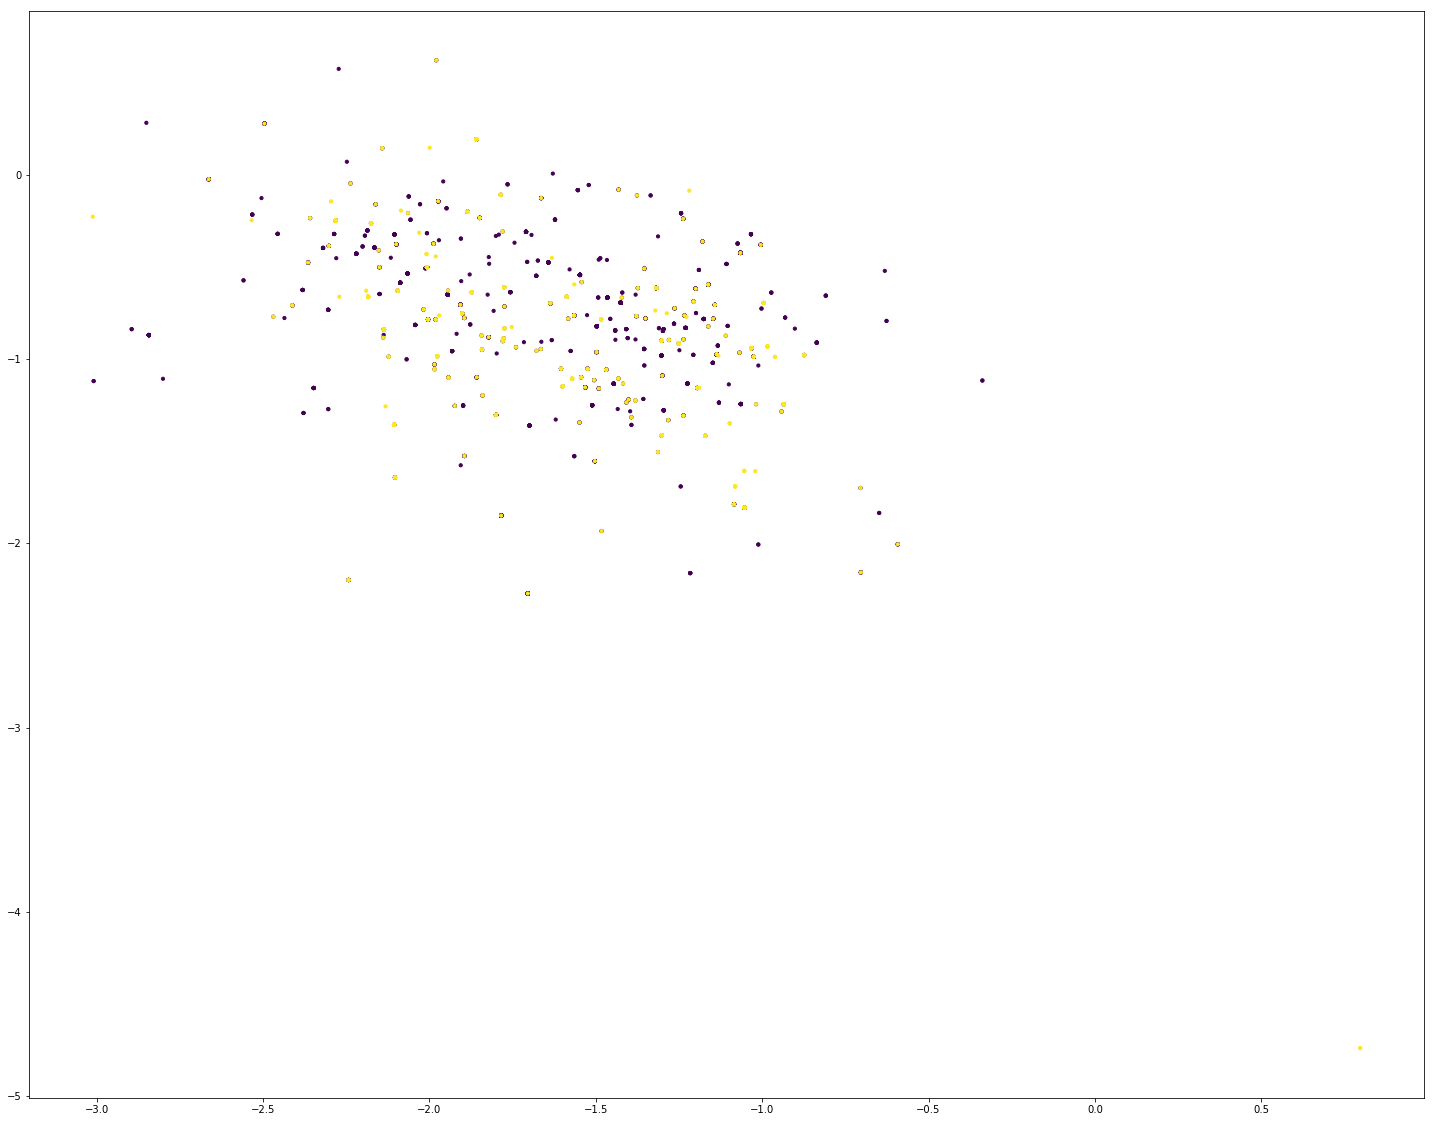

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 20))
plt.scatter(drawing[:, 0], drawing[:, 1], c=drawing[:, 2], s=10)
plt.show()